# Sampling True NCS Dataset

## Problem

To have a reliable classification algorithm, it is important to select a "representative" sample of noncoding sequences (dataset of negative examples). The current method of selecting noncoding sequences (NCS) is a simple one - find the largest open reading frame (ORF) in each intergenic region (space between genes). However, this doesn't seem to provide a representative sample of NCS. Rather, I will find all possible NCS in each intergenic region and sample them in a way such that their length and gc content resembles the distributions of coding sequences (CDS).

In [1]:
from Bio import Entrez
Entrez.email = "vignesh.ravindranath@gmail.com"

import numpy as np
from scipy import stats
from math import log

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from modules import preprocess, extract, utils

In [2]:
_cds, _ncs = preprocess.genome(filename='./input/train.txt', n_genomes=2)

Successfully fetched NC_000917
2478 CDS Records, 950 NCS Records

Successfully fetched NC_005966
3241 CDS Records, 1757 NCS Records

5719 Total CDS Records
2707 Total NCS Records


# Visualizing Length Data

## Plot Raw Length Data

In [3]:
def get_seq_len(records):
    lengths = []
    for record in records:
        lengths.append(len(record.seq))
    return lengths

In [4]:
# put data into tidy lists
labels = ['cds']*len(_cds) + ['ncs']*len(_ncs)

cds_seq_len = get_seq_len(_cds)
ncs_seq_len = get_seq_len(_ncs)

seq_len = cds_seq_len + ncs_seq_len 

# add data to pandas dataframe
data = {'label': labels, 'length': seq_len}
df = pd.DataFrame(data)
df.head()

,label,length
0,cds,555
1,cds,1821
2,cds,654
3,cds,678
4,cds,1314


In [5]:
df.length[df.label == 'cds'].describe()

count     5719.000000
mean       963.577374
std        606.194012
min        132.000000
25%        540.000000
50%        852.000000
75%       1227.000000
max      11196.000000
Name: length, dtype: float64

In [6]:
df.length[df.label == 'ncs'].describe()

count     2707.000000
mean      2319.572959
std       3333.271333
min        120.000000
25%        240.000000
50%       1086.000000
75%       3009.000000
max      38811.000000
Name: length, dtype: float64

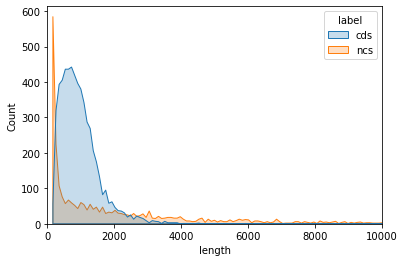

In [7]:
sns.histplot(df, x="length", hue="label", element="poly")
plt.xlim(0, 10000)
plt.show()

**Observations:** Both the cds and ncs length distributions seem to be positively skewed (data needs to be normalized). There is a larger range of ncs lengths (120, 38,811) compared to cds (132, 11,196).

## Plot Log Normal Length Data

Transform data to log normal to fix skewness.

In [8]:
def log_norm(data):
    return [log(x) for x in data]

In [9]:
# add log normal data to dataframe
df['log_norm_length'] = log_norm(cds_seq_len) + log_norm(ncs_seq_len)
df.head()

,label,length,log_norm_length
0,cds,555,6.318968
1,cds,1821,7.507141
2,cds,654,6.483107
3,cds,678,6.519147
4,cds,1314,7.180831


<AxesSubplot:xlabel='log_norm_length', ylabel='Count'>

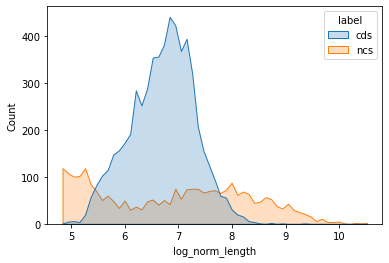

In [10]:
sns.histplot(df, x="log_norm_length", hue="label", element="poly")

**Observations:** The distributions of the cds and ncs lengths are not similar. 

# Visualizing GC Data

In [11]:
def get_gc_content(records):
    gc = []
    for record in records:
        gc.append(extract.extract_gc_content(record.seq))
    return gc

In [12]:
# add gc content data to dataframe
df['gc'] = get_gc_content(_cds) + get_gc_content(_ncs)
df.head()

,label,length,log_norm_length,gc
0,cds,555,6.318968,0.403604
1,cds,1821,7.507141,0.524437
2,cds,654,6.483107,0.466361
3,cds,678,6.519147,0.513274
4,cds,1314,7.180831,0.521309


In [13]:
df.gc[df.label == 'cds'].describe()

count    5719.000000
mean        0.437076
std         0.054248
min         0.219753
25%         0.400844
50%         0.433871
75%         0.482850
max         0.593870
Name: gc, dtype: float64

In [14]:
df.gc[df.label == 'ncs'].describe()

count    2707.000000
mean        0.390510
std         0.074878
min         0.116838
25%         0.338257
50%         0.394437
75%         0.444313
max         0.613645
Name: gc, dtype: float64

<AxesSubplot:xlabel='gc', ylabel='Count'>

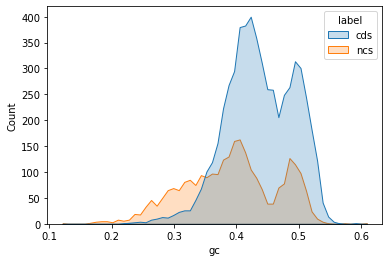

In [15]:
sns.histplot(df, x="gc", hue="label", element="poly")

**Observations:** The gc content distributions are similar, however, there are not as many ncs examples as there are cds examples.

# Probability Distribution Fitting to CDS
Ref: https://stackoverflow.com/questions/6620471/fitting-empirical-distribution-to-theoretical-ones-with-scipy-python

In [16]:
%matplotlib inline

import warnings
import numpy as np
import pandas as pd
import scipy.stats as st
import statsmodels.api as sm
from scipy.stats._continuous_distns import _distn_names
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)
matplotlib.style.use('ggplot')

In [17]:
# Create models from data
def best_fit_distribution(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Best holders
    best_distributions = []

    # Estimate distribution parameters from data
    for ii, distribution in enumerate([d for d in _distn_names if not d in ['levy_stable', 'studentized_range']]):

#         print("{:>3} / {:<3}: {}".format( ii+1, len(_distn_names), distribution ))

        distribution = getattr(st, distribution)

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')
                
                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]
                
                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))
                
                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                best_distributions.append((distribution, params, sse))
        
        except Exception:
            pass

    
    return sorted(best_distributions, key=lambda x:x[2])

def make_pdf(dist, params, size=10000):
    """Generate distributions's Probability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

## Finding Best Fitting Distributions for Raw CDS Lengths 

In [20]:
# Load data from statsmodels datasets
data = pd.Series(df.length[df.label == 'cds'])

Text(0, 0.5, 'Frequency')

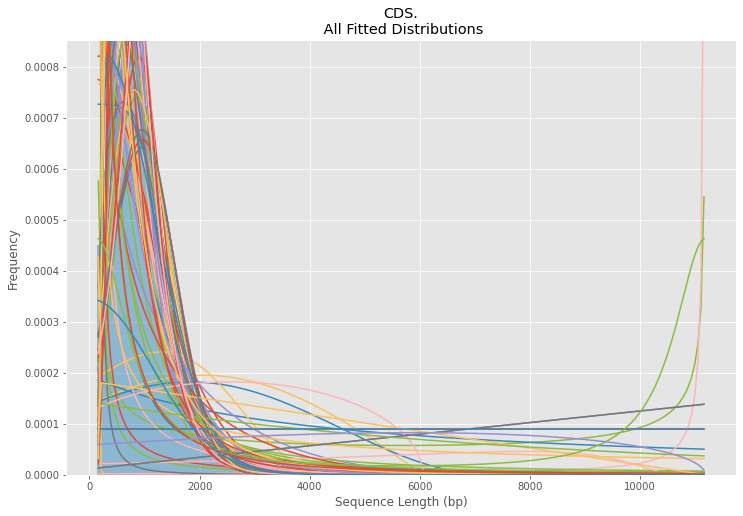

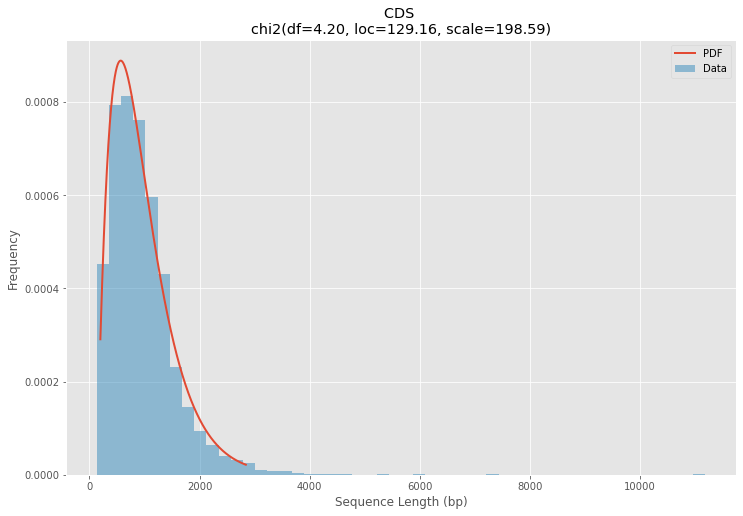

In [21]:
# Plot for comparison
plt.figure(figsize=(12,8))
ax = data.plot(kind='hist', bins=50, density=True, alpha=0.5, color=list(matplotlib.rcParams['axes.prop_cycle'])[1]['color'])

# # Save plot limits
dataYLim = ax.get_ylim()

# Find best fit distribution
best_distibutions = best_fit_distribution(data, 200, ax)
best_dist = best_distibutions[0]

# Update plots
ax.set_ylim(dataYLim)
ax.set_title(u'CDS.\n All Fitted Distributions')
ax.set_xlabel(u'Sequence Length (bp)')
ax.set_ylabel('Frequency')

# Make PDF with best params 
pdf = make_pdf(best_dist[0], best_dist[1])

# Display
plt.figure(figsize=(12,8))
ax = pdf.plot(lw=2, label='PDF', legend=True)
data.plot(kind='hist', bins=50, density=True, alpha=0.5, label='Data', legend=True, ax=ax)

param_names = (best_dist[0].shapes + ', loc, scale').split(', ') if best_dist[0].shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_dist[1])])
dist_str = '{}({})'.format(best_dist[0].name, param_str)

ax.set_title(u'CDS \n' + dist_str)
ax.set_xlabel(u'Sequence Length (bp)')
ax.set_ylabel('Frequency')

In [22]:
best_dist

(<scipy.stats._continuous_distns.chi2_gen at 0x7fee2212f940>,
 (4.204844657689029, 129.16051806044368, 198.5875356881558),
 1.584776014379315e-07)

**Observations: THIS MAY NOT BE REPRESENTATIVE OF ALL CDS -- ONLY 2 GENOMES WERE USED FOR THIS EXAMPLE.** For this example, a Chi Squared distribution seems to fit the small amount of data provided. These parameters can be saved and used to sample ncs sequences. More data should be used to find a more representative distribution for cds.

## Finding Best Fitting Distribution for Transformed (Log Norm) CDS Length Data

In [24]:
# Load data from statsmodels datasets
data = pd.Series(df.log_norm_length[df.label == 'cds'])

Text(0, 0.5, 'Frequency')

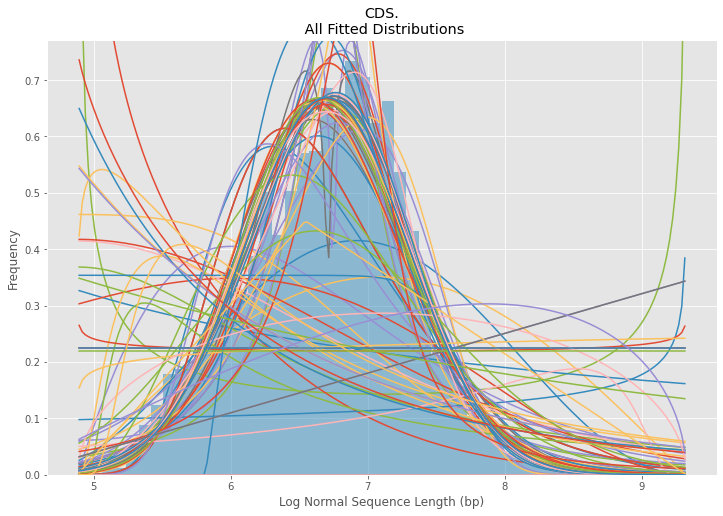

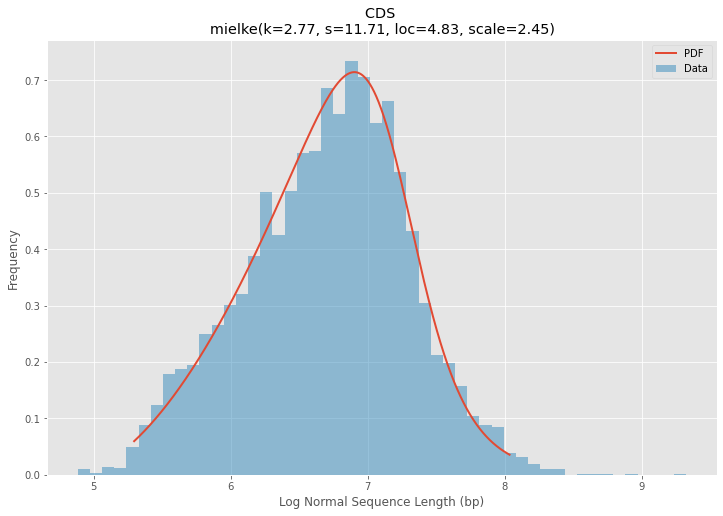

In [25]:
# Plot for comparison
plt.figure(figsize=(12,8))
ax = data.plot(kind='hist', bins=50, density=True, alpha=0.5, color=list(matplotlib.rcParams['axes.prop_cycle'])[1]['color'])

# # Save plot limits
dataYLim = ax.get_ylim()

# Find best fit distribution
best_distibutions = best_fit_distribution(data, 200, ax)
best_dist2 = best_distibutions[0]

# Update plots
ax.set_ylim(dataYLim)
ax.set_title(u'CDS.\n All Fitted Distributions')
ax.set_xlabel(u'Log Normal Sequence Length (bp)')
ax.set_ylabel('Frequency')

# Make PDF with best params 
pdf = make_pdf(best_dist2[0], best_dist2[1])

# Display
plt.figure(figsize=(12,8))
ax = pdf.plot(lw=2, label='PDF', legend=True)
data.plot(kind='hist', bins=50, density=True, alpha=0.5, label='Data', legend=True, ax=ax)

param_names = (best_dist2[0].shapes + ', loc, scale').split(', ') if best_dist2[0].shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_dist2[1])])
dist_str = '{}({})'.format(best_dist2[0].name, param_str)

ax.set_title(u'CDS \n' + dist_str)
ax.set_xlabel(u'Log Normal Sequence Length (bp)')
ax.set_ylabel('Frequency')

In [26]:
best_dist2

(<scipy.stats._continuous_distns.mielke_gen at 0x7fee21fe6190>,
 (2.768309488286796,
  11.714006349489127,
  4.830724553349501,
  2.4505164276298874),
 0.5856736741760287)

**Observations:** Not quite normal...hopefully with more data, the transformed cds data will look normal. If so, ncs lengths can be transformed (log_norm) and sampled within 3 sigmas.

## TODO: Fit Normal (Gaussian) Distribution to Log Normal CDS Length Data

## Define Probability Distribution and Try Sampling Data

Ref: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.erlang.html

In [113]:
import random
random.seed(8)

In [115]:
def pdist(x, best_dist):
    # define parameters from best fit distribution to cds
    a     = best_dist[1][0]
    loc   = best_dist[1][1]
    scale = best_dist[1][2]

    # sample (see probability of having a sequence of length x)
    r = random.randint(0,1000)
    return r * stats.erlang.pdf(x, a=a, loc=loc, scale=scale)

In [116]:
# what is the probability of seeing a sequence of length...
x = 150 # bp
prob = pdist(x=x, best_dist=best_dist)
print(f'{round(prob*100, 5)}%')

0.00981%


In [117]:
# what is the probability of seeing a sequence of length...
x = 2000 # bp
prob = pdist(x=x, best_dist=best_dist)
print(f'{round(prob*100, 5)}%')

2.62222%


# TODO: Sampling NCS to fit CDS Distribution

Now that we have fit a distribution to the CDS, we can update the functions in `preprocess.py` to extract all ORFs in each intergenic region and sample them accordingly. 

In [ ]:
def get_ncs_records_UPDATED(interregions, dna, acc_num, LMIN, OFFSET):
    ## interregion (i or intr)
    ## longest orf (long)
    
    ncs = []
    for interregion in interregions:
        feature = interregion.features[0]
        strand  = feature.strand
        
        # find longest orf in interregion
        i_start  = feature.location.start.position
        i_end    = feature.location.end.position
        intr_seq = dna[0][i_start:i_end] if strand == 1 else dna[1][::-1][i_start:i_end][::-1]
        
        # TODO: UPDATES HAPPENS HERE - find all orfs  
        # all_orfs = utils.orf_finder(intr_seq)
        # check if any
        # for orf in all_orfs
        #     check if sequence > LMIN
        #     check if probability of seeing sequence within 3 sigma
        #     add sequence to ncs
    
        long_orf = longest_orf(intr_seq.seq)  
        if not long_orf: continue                       # check if orf exists 
        if long_orf[1] - long_orf[0] < LMIN: continue   # check if orf length > l_min = 60
        
        tag   = interregion.name
        start = i_start + long_orf[0]
        end   = i_start + long_orf[1]

        m_start = start - OFFSET
        m_end = end + OFFSET
        
        m30   = (dna[0][m_start:start] if strand == 1 else dna[1][::-1][end-1:m_end-1][::-1]).seq
        seq   = intr_seq[long_orf[0]:long_orf[1]].seq
        p30   = (dna[0][end:m_end] if strand == 1 else dna[1][::-1][m_start-1:start-1][::-1]).seq
        
        f = [SeqFeature(FeatureLocation(start, end, strand), type='NCS')]
        r = SeqRecord(m30+seq+p30, name=tag, id=acc_num, features=f)
        ncs.append(r)
    
    return ncs

In [ ]:
prok_ids = preprocess.get_input_ids('./input/train.txt')
    
_cds_new, _ncs_new = [], []
for acc_num in prok_ids[0:2]:
    # SAME FIRST FEW STEPS
    print(f'Successfully fetched {acc_num}')
    seq_record = preprocess.entrez(acc_num, db="sequences", rettype="gbwithparts", file_format="gb")
    dna = [seq_record, seq_record.reverse_complement()]                
    cds = preprocess.get_cds_records(seq_record, dna, acc_num, LMIN=60, OFFSET=30) 
    interregions = preprocess.get_interregions(cds, seq_record)

    # UPDATES HAPPEN HERE
    ncs = get_ncs_records_UPDATED(interregions, dna, acc_num, LMIN=60, OFFSET=30)

    # SAVE DATA
    _cds_new.extend(cds)
    _ncs_new.extend(ncs)
    print(f'{len(cds)} CDS Records, {len(ncs)} NCS Records\n')

print(f'{len(_cds_new)} Total CDS Records')
print(f'{len(_ncs_new)} Total NCS Records')

## TODO: Visualize CDS and Sampled NCS Distributions